In [1]:
import os
os.listdir()

['.DS_Store',
 '2020年15分钟华东及四省一市的调度口径负荷.xlsx',
 '深度嵌入聚类.ipynb',
 '20191201至20201109华东及四省一市风光96点出力及装机容量.xlsx',
 '基于深度嵌入聚类的水光荷不确定性源场景生成方法_杨晶显.pdf',
 '.ipynb_checkpoints']

In [2]:
import pandas as pd
data1 = pd.read_excel('2020年15分钟华东及四省一市的调度口径负荷.xlsx')

In [3]:
data11 = pd.read_excel('20191201至20201109华东及四省一市风光96点出力及装机容量.xlsx')

In [4]:
data2 = pd.merge(data1,data11,on = '时间')
del data2['   _x']
del data2['   _y']
del data2['省市']

In [5]:
data2 = data2.fillna(axis=0,method='ffill')

In [6]:
data2 = data2[['时间','用电负荷(MW)', '风电有功发电（MW）','光伏有功发电（MW）']]

### 数据分析与数据预处理

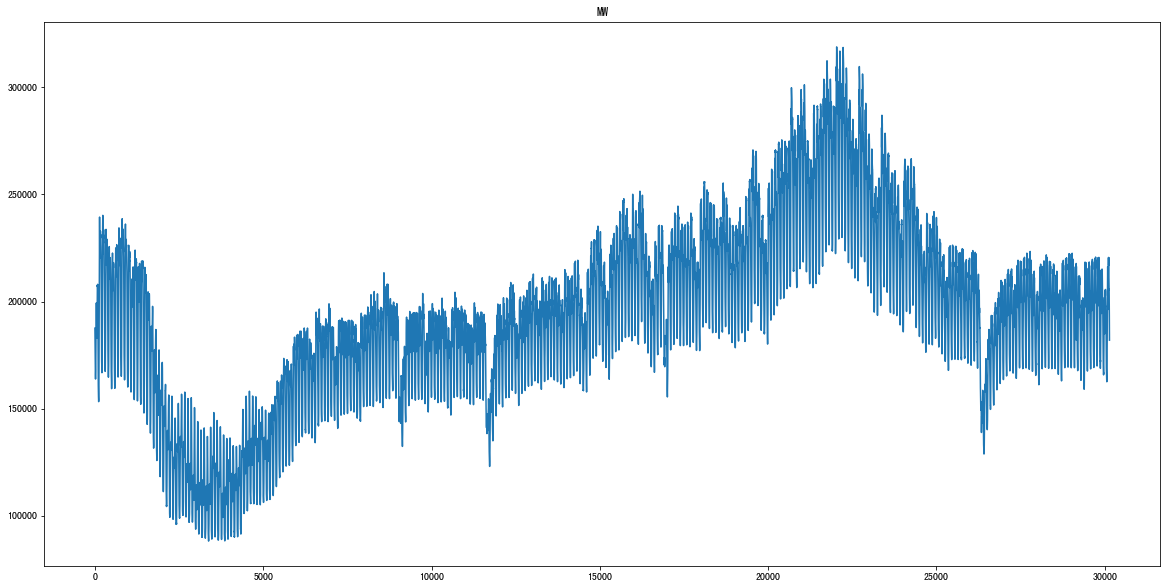

In [7]:
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.figure(figsize = (20,10))
plt.title('MW')
plt.plot(data2['用电负荷(MW)'])
plt.show()

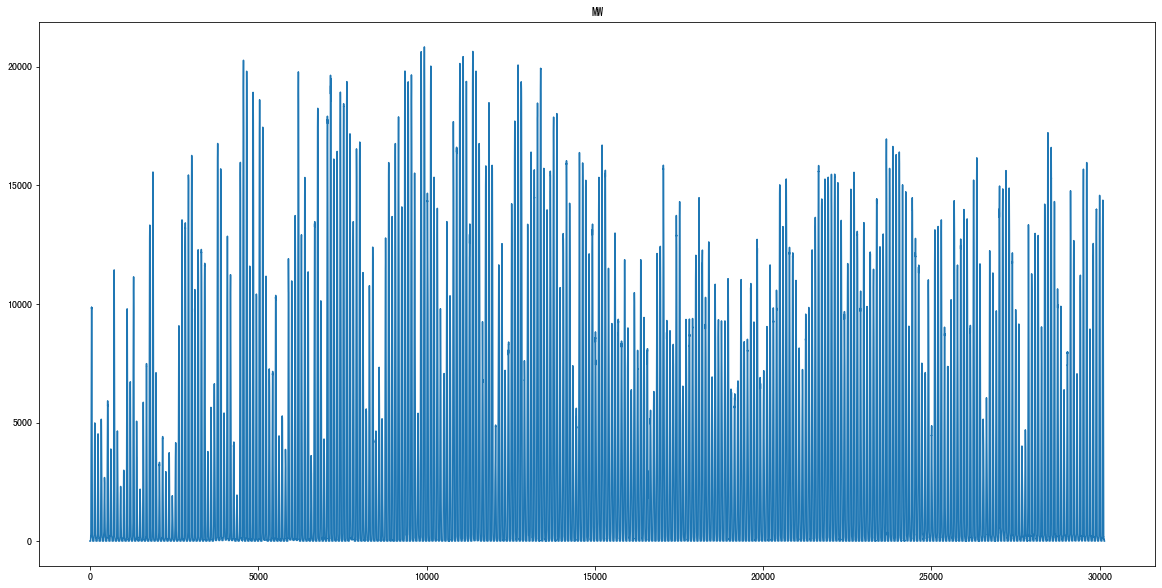

In [8]:
plt.figure(figsize = (20,10))
plt.title('MW')
plt.plot(data2['光伏有功发电（MW）'])
plt.show()

### 高斯滤波可视化

In [9]:
from scipy.ndimage import gaussian_filter
import cv2

a1 =data2['风电有功发电（MW）']
result1 = gaussian_filter(a1, sigma=5)

a2 =data2['光伏有功发电（MW）']
result2 = gaussian_filter(a2, sigma=5)

a3 =data2['用电负荷(MW)']
result3 = gaussian_filter(a3, sigma=5)

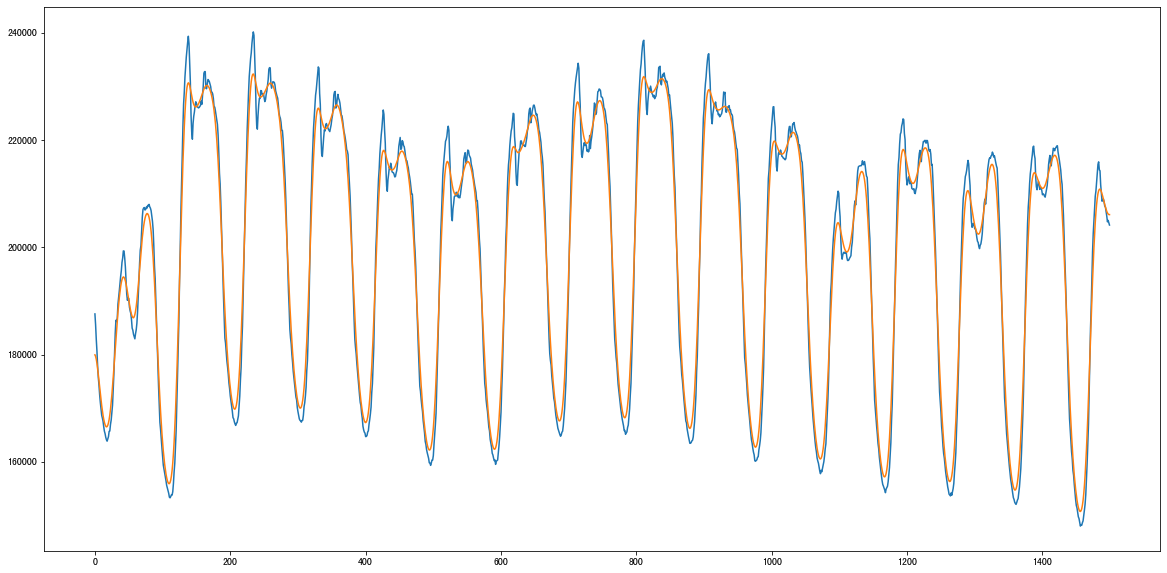

In [10]:
plt.figure(figsize = (20,10))
plt.plot(a3[:1500])
plt.plot(result3[:1500])

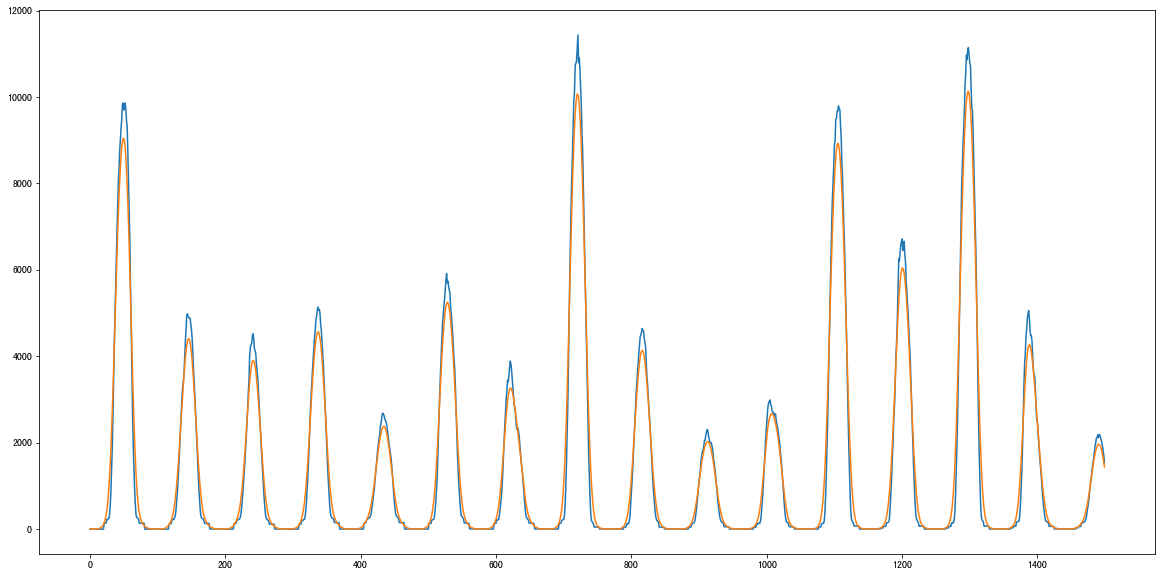

In [11]:
plt.figure(figsize = (20,10))
plt.plot(a2[:1500])
plt.plot(result2[:1500])

### 高斯滤波后误差图

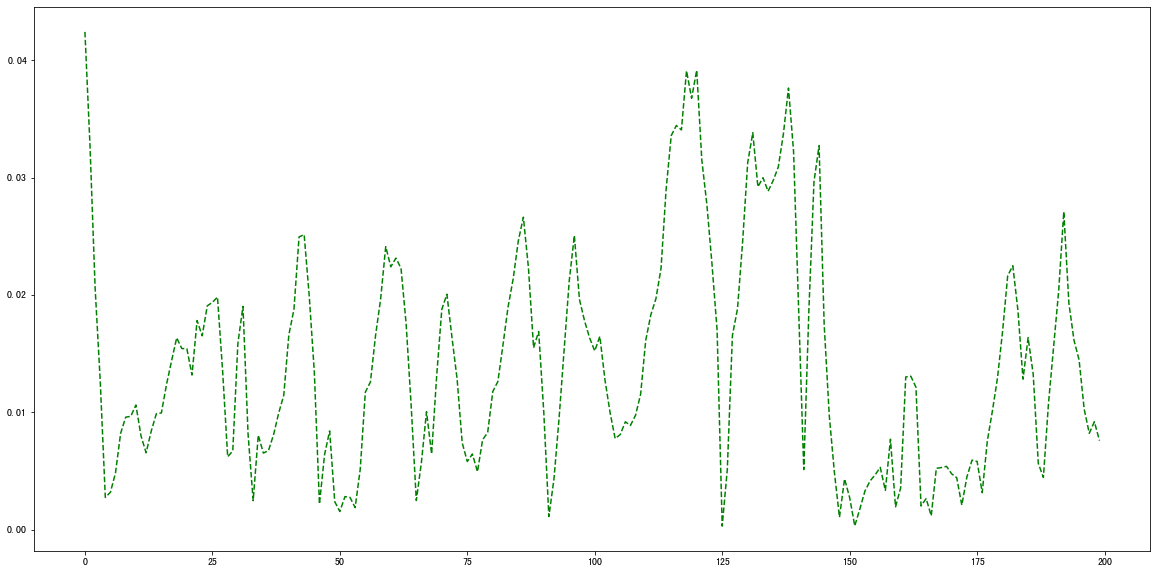

In [12]:
plt.figure(figsize = (20,10))
plt.plot(abs((a3[:200] - result3[:200])/result3[:200]),'g--')

### 归一化

In [13]:
from sklearn import preprocessing
my_data = data2.values[:,1:]

min_max_scaler = preprocessing.MinMaxScaler()
x_minmax = min_max_scaler.fit_transform(my_data)
print(x_minmax)

[[4.30937784e-01 2.83374512e-01 1.86489990e-07]
 [4.22069347e-01 2.76607675e-01 1.86489990e-07]
 [4.10236794e-01 2.69358029e-01 9.34129174e-08]
 ...
 [4.28207372e-01 3.13605870e-01 8.13579972e-06]
 [4.17212378e-01 3.17030817e-01 9.09813988e-06]
 [4.06578161e-01 3.14615742e-01 8.41335171e-06]]


### 肘部法则确定最佳聚类数

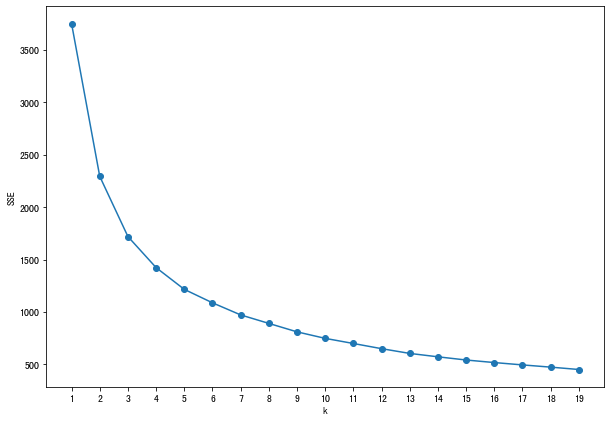

In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# '利用SSE选择k'
SSE = []  # 存放每次结果的误差平方和
for k in range(1, 20):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(x_minmax)
    SSE.append(estimator.inertia_)
X = range(1, 20)
plt.figure(figsize = (10,7))
plt.xticks(np.arange(1,20))
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X, SSE, 'o-')
plt.show()

### 聚类中心

In [15]:
estimator.cluster_centers_

array([[0.42893973, 0.15013633, 0.01747111],
       [0.8213991 , 0.19624439, 0.6254365 ],
       [0.34103518, 0.43040455, 0.01383461],
       [0.50713284, 0.41709486, 0.3369237 ],
       [0.38368817, 0.75125749, 0.02821567],
       [0.4988745 , 0.33344792, 0.02441491],
       [0.16346914, 0.25083481, 0.4615851 ],
       [0.5104742 , 0.17602766, 0.54253143],
       [0.59180974, 0.16181274, 0.03077034],
       [0.41967732, 0.57236815, 0.68189355],
       [0.7802931 , 0.34142609, 0.03208749],
       [0.09641098, 0.25952782, 0.02973531],
       [0.73341442, 0.20287738, 0.36663601],
       [0.30535732, 0.22259198, 0.01265135],
       [0.62166113, 0.66945437, 0.37006178],
       [0.51037042, 0.15663387, 0.25948599],
       [0.16237257, 0.57228409, 0.02702093],
       [0.39936131, 0.22196092, 0.79149372],
       [0.53037309, 0.54621958, 0.03964396]])

### 根据肘部法则，我们认为最优分类数为5

In [16]:
estimator = KMeans(n_clusters=5)  # 构造聚类器
estimator.fit(x_minmax)

KMeans(n_clusters=5)

## 搭建一个神经网络

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
y = pd.get_dummies(estimator.labels_).values
X_train, X_test, y_train, y_test = train_test_split(x_minmax, y, test_size=0.2, random_state=0)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD

model_ml = Sequential()
model_ml.add(Dense(5, input_shape=(3,), activation='relu'))
model_ml.add(Dense(8, activation='relu'))
model_ml.add(Dense(2, activation='relu'))
#这里设置为我们认为的最佳聚类数
model_ml.add(Dense(5, activation='softmax'))
#设置损失函数是kl散度损失函数
model_ml.compile(Adam(lr=0.04), 'kullback_leibler_divergence', metrics=['accuracy'])
model_ml.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 20        
                                                                 
 dense_1 (Dense)             (None, 8)                 48        
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
 dense_3 (Dense)             (None, 5)                 15        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_ml2 = Sequential()
model_ml2.add(Dense(5, input_shape=(3,), activation='relu'))
model_ml2.add(Dense(8, activation='relu'))
model_ml2.add(Dense(2, activation='relu'))
model_ml2.add(Dense(5, activation='softmax'))

model_ml2.compile(SGD(lr=0.02), 'kullback_leibler_divergence', metrics=['accuracy'])
model_ml2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 5)                 20        
                                                                 
 dense_5 (Dense)             (None, 8)                 48        
                                                                 
 dense_6 (Dense)             (None, 2)                 18        
                                                                 
 dense_7 (Dense)             (None, 5)                 15        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist1 = model_ml.fit(X_train, y_train, epochs=100)

Epoch 1/100
754/754 [==============================] - 1s 755us/step - loss: 0.9218 - accuracy: 0.6017
Epoch 2/100
754/754 [==============================] - 1s 692us/step - loss: 0.6030 - accuracy: 0.7977
Epoch 3/100
754/754 [==============================] - 1s 692us/step - loss: 0.5527 - accuracy: 0.8163
Epoch 4/100
754/754 [==============================] - 1s 675us/step - loss: 0.4926 - accuracy: 0.8347
Epoch 5/100
754/754 [==============================] - 1s 690us/step - loss: 0.4638 - accuracy: 0.8436
Epoch 6/100
754/754 [==============================] - 1s 694us/step - loss: 0.4935 - accuracy: 0.8397
Epoch 7/100
754/754 [==============================] - 0s 654us/step - loss: 0.4459 - accuracy: 0.8457
Epoch 8/100
754/754 [==============================] - 1s 699us/step - loss: 0.4497 - accuracy: 0.8466
Epoch 9/100
754/754 [==============================] - 1s 717us/step - loss: 0.4290 - accuracy: 0.8522
Epoch 10/100
754/754 [==============================] - 1s 700us/step - l

754/754 [==============================] - 1s 926us/step - loss: 0.4064 - accuracy: 0.8688
Epoch 80/100
754/754 [==============================] - 1s 880us/step - loss: 0.3797 - accuracy: 0.8734
Epoch 81/100
754/754 [==============================] - 1s 888us/step - loss: 0.4035 - accuracy: 0.8696
Epoch 82/100
754/754 [==============================] - 1s 665us/step - loss: 0.4045 - accuracy: 0.8676
Epoch 83/100
754/754 [==============================] - 1s 682us/step - loss: 0.3871 - accuracy: 0.8683
Epoch 84/100
754/754 [==============================] - 1s 673us/step - loss: 0.4078 - accuracy: 0.8678
Epoch 85/100
754/754 [==============================] - 1s 826us/step - loss: 0.3973 - accuracy: 0.8712
Epoch 86/100
754/754 [==============================] - 1s 947us/step - loss: 0.3927 - accuracy: 0.8704
Epoch 87/100
754/754 [==============================] - 1s 847us/step - loss: 0.3905 - accuracy: 0.8711
Epoch 88/100
754/754 [==============================] - 1s 855us/step - loss:

In [ ]:
hist2 = model_ml2.fit(X_train, y_train, epochs=100)

Epoch 1/100
754/754 [==============================] - 1s 617us/step - loss: 1.4408 - accuracy: 0.3993
Epoch 2/100
754/754 [==============================] - 0s 610us/step - loss: 1.2095 - accuracy: 0.5084
Epoch 3/100
754/754 [==============================] - 1s 664us/step - loss: 1.1137 - accuracy: 0.5365
Epoch 4/100
754/754 [==============================] - 0s 626us/step - loss: 1.0669 - accuracy: 0.5728
Epoch 5/100
754/754 [==============================] - 0s 653us/step - loss: 1.0282 - accuracy: 0.5974
Epoch 6/100
754/754 [==============================] - 0s 656us/step - loss: 0.9957 - accuracy: 0.6103
Epoch 7/100
754/754 [==============================] - 1s 687us/step - loss: 0.9660 - accuracy: 0.6197
Epoch 8/100
754/754 [==============================] - 1s 814us/step - loss: 0.9403 - accuracy: 0.6302
Epoch 9/100
754/754 [==============================] - 0s 630us/step - loss: 0.9147 - accuracy: 0.6412
Epoch 10/100
754/754 [==============================] - 0s 622us/step - l

In [ ]:
# 创建一个绘图窗口
plt.figure()
 
acc1 = hist1.history['accuracy']
acc2 = hist2.history['accuracy']
loss = hist1.history['loss']
loss2 = hist2.history['loss']
 
epochs = range(len(acc2))
 
plt.plot(epochs, acc1, 'r', label='Adam acc') # 'bo'为画蓝色圆点，不连线
plt.plot(epochs, acc2, 'b', label='SGD acc') 
plt.title('Training and validation accuracy')
plt.legend() # 绘制图例，默认在右上角
 
plt.figure()
 
plt.plot(epochs, loss, 'r', label='Adam loss')
plt.plot(epochs, loss2, 'b', label='SGD loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
# 第三步：将模型作为一个层，输出第7层的输出

layer_model = Model(inputs=model_ml2.input, outputs=model_ml2.layers[2].output)
feature3=layer_model.predict(x_minmax)
print(feature3.shape)

##提取出三个数据集

In [ ]:
data2['hour'] = data2['时间'].apply(lambda x : (x - data2['时间'][0]).days * 100 + (x - data2['时间'][0]).seconds//3600)
data2['day'] = data2['时间'].apply(lambda x : (x - data2['时间'][0]).days)

In [ ]:
namelist = ['用电负荷(MW)','风电有功发电（MW）', '光伏有功发电（MW）']

In [ ]:
data3 = pd.DataFrame(feature3)
data3['day'] = data2['day']
temp2 = data3.groupby(data2['day']).mean()
value = temp2.values[:,:2]
estimator = KMeans(n_clusters=5)  # 构造聚类器
estimator.fit(value)
answer = estimator.labels_

In [ ]:
classifer = 3
print(data2['时间'][np.where(answer == classifer)[0] * 24 * 4])

plt.figure(figsize = (15,10))
plt.subplot(3,1,1)
temp = list(data2.groupby(data2['hour'])[namelist[0]].mean())
temp3 = np.where(answer == classifer)[0]
for i in range(len(temp3)):
    plt.plot(temp[int(temp3[i]*24):int((temp3[i] + 1)*24)])
    plt.ylabel('electrical')
    plt.title('class' + str(classifer),fontsize = 15)
plt.subplot(3,1,2)
temp = list(data2.groupby(data2['hour'])[namelist[1]].mean())
for i in range(len(temp3)):
    plt.plot(temp[int(temp3[i]*24):int((temp3[i] + 1)*24)])
    plt.ylabel('wind')
plt.subplot(3,1,3)
temp = list(data2.groupby(data2['hour'])[namelist[2]].mean())
for i in range(len(temp3)):
    plt.plot(temp[int(temp3[i]*24):int((temp3[i] + 1)*24)])
    plt.xlabel('t/h')
    plt.ylabel('light')

## 多方法对比

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_minmax)
pca_data = pca.transform(x_minmax)

In [ ]:
pca_answer1 = []
pca_answer2 = []
pca_answer3 = []
for i in range(4,11):
    estimator = KMeans(n_clusters=i)  # 构造聚类器
    estimator.fit(pca_data)
    pca_answer1.append(silhouette_score(pca_data,estimator.labels_))
    pca_answer2.append(calinski_harabasz_score(pca_data,estimator.labels_))
    pca_answer3.append(davies_bouldin_score(pca_data,estimator.labels_))

In [ ]:
kmeans_answer1 = []
kmeans_answer2 = []
kmeans_answer3 = []
for i in range(4,11):
    estimator = KMeans(n_clusters=i)  # 构造聚类器
    estimator.fit(x_minmax)
    kmeans_answer1.append(silhouette_score(x_minmax,estimator.labels_))
    kmeans_answer2.append(calinski_harabasz_score(x_minmax,estimator.labels_))
    kmeans_answer3.append(davies_bouldin_score(x_minmax,estimator.labels_))

In [ ]:
my_answer1 = []
my_answer2 = []
my_answer3 = []
for i in range(4,11):
    
    estimator = KMeans(n_clusters=i)  # 构造聚类器
    estimator.fit(x_minmax)
    
    y = pd.get_dummies(estimator.labels_).values
    
    X_train, X_test, y_train, y_test = train_test_split(x_minmax, y, test_size=0.2, random_state=0)
    
    model_ml2 = Sequential()
    model_ml2.add(Dense(5, input_shape=(3,), activation='relu'))
    model_ml2.add(Dense(8, activation='relu'))
    model_ml2.add(Dense(2, activation='relu'))
    #model_ml.add(Dense(4, activation='relu'))
    model_ml2.add(Dense(i, activation='softmax'))

    model_ml2.compile(SGD(lr=0.02), 'kullback_leibler_divergence', metrics=['accuracy'])
    
    hist2 = model_ml2.fit(X_train, y_train, epochs=100)
    
    layer_model = Model(inputs=model_ml2.input, outputs=model_ml2.layers[2].output)
    feature=layer_model.predict(x_minmax)
    estimator = KMeans(n_clusters=i)  # 构造聚类器
    estimator.fit(feature)
    my_answer1.append(silhouette_score(feature,estimator.labels_))
    my_answer2.append(calinski_harabasz_score(feature,estimator.labels_))
    my_answer3.append(davies_bouldin_score(feature,estimator.labels_))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (10,8))
# 输入统计数据
waters = np.arange(4,11)
buy_number_male = kmeans_answer1
buy_number_female = pca_answer1
buy_number_mine = my_answer1

bar_width = 0.25  # 条形宽度
index_male = np.arange(len(waters))  # 男生条形图的横坐标
index_female = index_male + bar_width  # 女生条形图的横坐标
index_mine = index_male + 2*bar_width  # 女生条形图的横坐标

# 使用两次 bar 函数画出两组条形图
plt.bar(index_male, height=buy_number_male, width=bar_width, color='g', label='kmeans')
plt.bar(index_female, height=buy_number_female, width=bar_width, color='b', label='pca + kmeans')
plt.bar(index_mine, height=buy_number_mine, width=bar_width, color='r', label='DEC')


plt.legend()  # 显示图例
plt.xticks(index_male + bar_width, waters)  # 让横坐标轴刻度显示 waters 里的饮用水， index_male + bar_width/2 为横坐标轴刻度的位置
plt.ylabel('silhouette_score')  # 纵坐标轴标题
plt.title('Comparison of three methods in silhouette_score')  # 图形标题

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (10,8))
# 输入统计数据
waters = np.arange(4,11)
buy_number_male = kmeans_answer2
buy_number_female = pca_answer2
buy_number_mine = my_answer2

bar_width = 0.25  # 条形宽度
index_male = np.arange(len(waters))  # 男生条形图的横坐标
index_female = index_male + bar_width  # 女生条形图的横坐标
index_mine = index_male + 2*bar_width  # 女生条形图的横坐标

# 使用两次 bar 函数画出两组条形图
plt.bar(index_male, height=buy_number_male, width=bar_width, color='g', label='kmeans')
plt.bar(index_female, height=buy_number_female, width=bar_width, color='b', label='pca + kmeans')
plt.bar(index_mine, height=buy_number_mine, width=bar_width, color='r', label='DEC')


plt.legend()  # 显示图例
plt.xticks(index_male + bar_width, waters)  # 让横坐标轴刻度显示 waters 里的饮用水， index_male + bar_width/2 为横坐标轴刻度的位置
plt.ylabel('calinski_harabasz_score')  # 纵坐标轴标题
plt.title('Comparison of three methods in calinski_harabasz_score')  # 图形标题

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize = (10,8))
# 输入统计数据
waters = np.arange(4,11)
buy_number_male = kmeans_answer3
buy_number_female = pca_answer3
buy_number_mine = my_answer3

bar_width = 0.25  # 条形宽度
index_male = np.arange(len(waters))  # 男生条形图的横坐标
index_female = index_male + bar_width  # 女生条形图的横坐标
index_mine = index_male + 2*bar_width  # 女生条形图的横坐标

# 使用两次 bar 函数画出两组条形图
plt.bar(index_male, height=buy_number_male, width=bar_width, color='g', label='kmeans')
plt.bar(index_female, height=buy_number_female, width=bar_width, color='b', label='pca + kmeans')
plt.bar(index_mine, height=buy_number_mine, width=bar_width, color='r', label='DEC')


plt.legend()  # 显示图例
plt.xticks(index_male + bar_width, waters)  # 让横坐标轴刻度显示 waters 里的饮用水， index_male + bar_width/2 为横坐标轴刻度的位置
plt.ylabel('davies_bouldin_score')  # 纵坐标轴标题
plt.title('Comparison of three methods in davies_bouldin_score')  # 图形标题

plt.show()